In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
import xgboost as xgb


In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv -O AB_NYC_2019.csv

--2021-10-18 18:39:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6,8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6,75M  1,18MB/s    in 5,5s    

2021-10-18 18:39:59 (1,23 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df['price_log'] = np.log1p(df['price'])
del df['price']
df.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_log
0,Brooklyn,40.64749,-73.97237,Private room,1,9,0.21,6,365,5.010635
1,Manhattan,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355,5.420535
2,Manhattan,40.80902,-73.94190,Private room,3,0,0.00,1,365,5.017280
3,Brooklyn,40.68514,-73.95976,Entire home/apt,1,270,4.64,1,194,4.499810
4,Manhattan,40.79851,-73.94399,Entire home/apt,10,9,0.10,1,0,4.394449


In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
y_train = df_train['price_log'].values
y_val = df_val['price_log'].values
y_test = df_test['price_log'].values

del df_train['price_log']
del df_val['price_log']
del df_test['price_log']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [7]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [8]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [10]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)

print(round(rmse, 3))

0.46


What's the RMSE of this model on validation?

* 0.059
* 0.259
* **0.459**
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [11]:
list_rmse = []

for n in range(10, 201, 10):
  rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
  rfr.fit(X_train, y_train)

  y_pred = rfr.predict(X_val)
  
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  list_rmse.append((n, rmse))

In [12]:
def addlabels(X,y):
  for i, x in enumerate(X):
    plt.text(x,y[i],round(y[i], 3), ha='center')

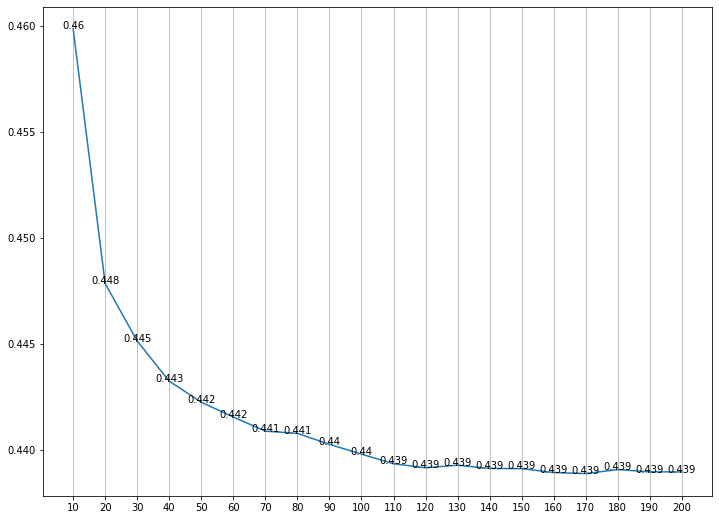

In [13]:
columns = ['n_estimators', 'rmse']
df_rmse = pd.DataFrame(list_rmse, columns=columns)

plt.figure(figsize=(12, 9))
plt.plot(df_rmse.n_estimators, df_rmse.rmse)
plt.grid(b=True, axis='x')
addlabels(range(10, 201, 10), df_rmse.rmse)
plt.xticks(ticks = range(10, 201, 10), label = range(10, 201, 10))
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [14]:
for m in [10, 15, 20, 25]:
  score = []
  for n in range(10, 201, 10):
    rfr = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    score.append(rmse)
    
    list_rmse.append((m, n, rmse))
  
  print("average RMSE for max_depth = {:d} is {:f}".format(m, (sum(score)/len(score))))
  print("")

average RMSE for max_depth = 10 is 0.440619

average RMSE for max_depth = 15 is 0.437732

average RMSE for max_depth = 20 is 0.440616

average RMSE for max_depth = 25 is 0.441806



What's the best `max_depth`:

* 10
* **15**
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

In [24]:
for r in [1, 10, 100]:
  score = []
  for n in range(10, 201, 10):
    rfr = RandomForestRegressor(n_estimators=n, max_depth=15, random_state=r, n_jobs=-1)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    score.append(rmse)
    
    list_rmse.append((m, n, rmse))
  
  print("average RMSE for random_state = {:d} is {:f}".format(m, (sum(score)/len(score))))
  print("")

average RMSE for random_state = 25 is 0.437732

average RMSE for random_state = 25 is 0.437184

average RMSE for random_state = 25 is 0.437748



## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [15]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

feature_importances = []
for i in range(15):
  feature_importances.append((dv.get_feature_names()[i], rfr.feature_importances_[i]))

df_fi = pd.DataFrame(feature_importances, columns=["feature_name", "feature_importances"])

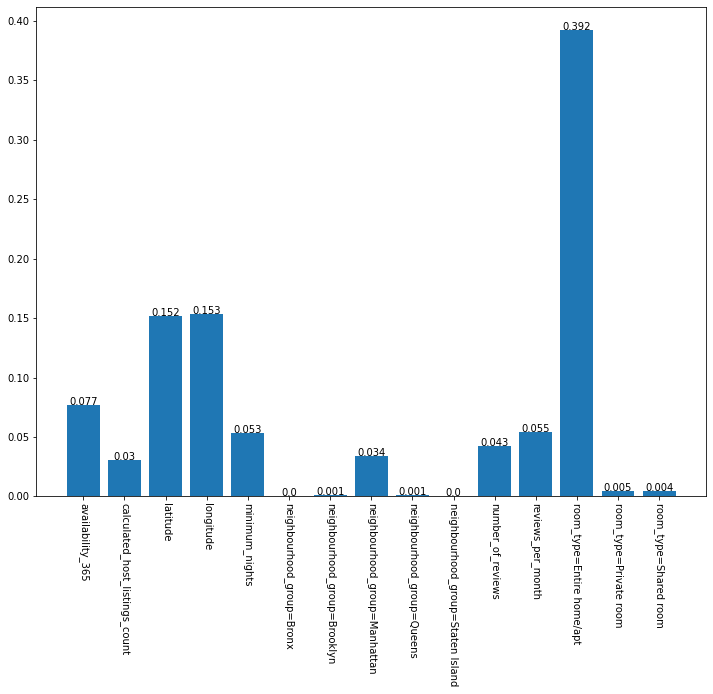

In [16]:
plt.figure(figsize=(12, 9))
plt.bar(df_fi.feature_name, df_fi.feature_importances)
plt.xticks(rotation=270)
addlabels(range(15), df_fi.feature_importances)
plt.show()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [17]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [18]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [19]:
print("RMSE for eta = 0.3 is {:f}".format(rmse))

RMSE for eta = 0.3 is 0.436210


Now change `eta` first to `0.1` and then to `0.01`

In [20]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [21]:
print("RMSE for eta = 0.1 is {:f}".format(rmse))

RMSE for eta = 0.1 is 0.432497


In [22]:
%%capture output
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [23]:
print("RMSE for eta = 0.01 is {:f}".format(rmse))

RMSE for eta = 0.01 is 1.630452


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* 0.01